In [245]:
# python=3.8
# conda env name : gender_pred_env

# Packges

In [246]:
import numpy as np
import pandas as pd
import warnings
import mlflow
import mlflow.keras
from mlflow.models.signature import infer_signature
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Adjusting warnings
warnings.filterwarnings('ignore')

In [247]:
# Load Data
df = pd.read_pickle('data/dataset_after_preporcessing.pkl')
df.head()

,name,sex,last_letter_ء,last_letter_أ,last_letter_ؤ,last_letter_ئ,last_letter_ا,last_letter_ب,last_letter_ة,last_letter_ت,...,first_letter_غ,first_letter_ف,first_letter_ق,first_letter_ك,first_letter_ل,first_letter_م,first_letter_ن,first_letter_ه,first_letter_و,first_letter_ي
0,ابتسام,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ابتهاج,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ابتهال,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,اجتهاد,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ازدهار,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [248]:
max_name_length = max(df['name'].apply(len))
unique_chars = set(''.join(df['name']))  
vocab_size = len(unique_chars) + 1  

# Tokenizing and padding the 'name' column for LSTM input
tokenizer = Tokenizer(num_words=vocab_size, char_level=True)  # char_level=True for character tokenization
tokenizer.fit_on_texts(df['name'])
sequences = tokenizer.texts_to_sequences(df['name'])
padded_sequences = pad_sequences(sequences, maxlen=max_name_length)

In [249]:
# Preparing additional features
additional_features = df.iloc[:,2:].values
additional_features = additional_features.astype('float32')

In [250]:
X = np.hstack((padded_sequences, additional_features))
y = df.sex

In [251]:
X.shape,y.shape

((8653, 84), (8653,))

In [252]:
# Define the size for the test and validation sets as percentages
test_size_percentage = 0.1
validation_size_percentage = 0.1

# Calculate the actual sizes for the test and validation sets
total_size = test_size_percentage + validation_size_percentage
test_size_actual = test_size_percentage / total_size
validation_size_actual = validation_size_percentage / total_size

# Calculate the training size percentage
train_size_percentage = 1 - total_size

# First split: Separate out the training data and the remaining data
X_train, X_remaining, y_train, y_remaining = train_test_split(X, y, test_size=total_size, random_state=11)

# Second split: Separate the remaining data into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_remaining, y_remaining, test_size=test_size_actual, random_state=11)

# Print the shapes of the training, validation, and test sets
print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Validation set shape: {X_val.shape}, {y_val.shape}")
print(f"Test set shape: {X_test.shape}, {y_test.shape}")

Training set shape: (6922, 84), (6922,)
Validation set shape: (865, 84), (865,)
Test set shape: (866, 84), (866,)


In [253]:
# Model parameters
embedding_dim = 256
lstm_units = 64
max_name_length = 17  # Adjust based on your data
total_features_shape = X.shape[1]  # Total features after combining name embeddings and additional features
l2_lambda = 0.000
dropout_rate = 0.0

batch_size = 32
epochs = 20

In [254]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Define the BiLSTM model adjusted for character-level input
model = Sequential()

model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim, input_length=total_features_shape))

model.add(Bidirectional(LSTM(lstm_units, return_sequences=True)))

model.add(Dropout(dropout_rate))

model.add(Bidirectional(LSTM(lstm_units//2, kernel_regularizer=l2(l2_lambda))))

model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_21 (Embedding)    (None, 84, 256)           9472      
                                                                 
 bidirectional_44 (Bidirecti  (None, 84, 128)          164352    
 onal)                                                           
                                                                 
 dropout_21 (Dropout)        (None, 84, 128)           0         
                                                                 
 bidirectional_45 (Bidirecti  (None, 64)               41216     
 onal)                                                           
                                                                 
 dense_24 (Dense)            (None, 1)                 65        
                                                                 
Total params: 215,105
Trainable params: 215,105
Non-t

In [255]:
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("Gender Prediction Models Tracking")

<Experiment: artifact_location='mlflow-artifacts:/237850698007442871', creation_time=1704716553191, experiment_id='237850698007442871', last_update_time=1704716553191, lifecycle_stage='active', name='Gender Prediction Models Tracking', tags={}>

In [256]:
# MLflow tracking
with mlflow.start_run():
    # Log model parameters
    mlflow.log_params({
        "embedding_dim": embedding_dim,
        "lstm_units": lstm_units,
        "max_name_length": max_name_length,
        "vocab_size": vocab_size,
        "epochs": epochs,
        "batch_size": batch_size,
        "l2_reg": l2_lambda,
        "dropout_rate": dropout_rate,
        "train_size_percentage": train_size_percentage,
        "test_size_percentage": test_size_percentage,
        "validation_size_percentage": validation_size_percentage,
    })

    # Train the model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping])

    # Log training history
    for epoch in range(len(history.history['accuracy'])):
        mlflow.log_metric("train_accuracy", history.history['accuracy'][epoch], step=epoch)
        mlflow.log_metric("val_accuracy", history.history['val_accuracy'][epoch], step=epoch)

    # Evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test)
    mlflow.log_metrics({"val_loss": loss, "val_accuracy": accuracy})

    # Predictions and additional metrics
    y_pred = model.predict(X_test)
    y_pred_classes = np.where(y_pred > 0.5, 1, 0).reshape(-1)
    f1 = f1_score(y_test, y_pred_classes)
    precision = precision_score(y_test, y_pred_classes)
    recall = recall_score(y_test, y_pred_classes)
    roc_auc = roc_auc_score(y_test, y_pred)

    # Log additional metrics
    mlflow.log_metrics({"val_f1_score": f1, "val_precision": precision, "val_recall": recall, "val_roc_auc": roc_auc})

    # Log model architecture
    model_architecture_str = []

    # Define a function to append each line of the model summary to the list
    def append_model_summary(line):
        model_architecture_str.append(line)

    # Generate model summary
    model.summary(print_fn=append_model_summary)

    # Convert list to string
    model_architecture_str = '\n'.join(model_architecture_str)

    # Infer the signature using the combined data and predictions
    signature = infer_signature(X, y_pred)

    mlflow.keras.log_model(model, "model", signature=signature)

    # Set additional tags
    mlflow.set_tags({
        "Description": "Character-Level BiLSTM with One-Hot Encoded Features",
        "Encoding": "One-Hot Encoding for Categorical Features",
        "Features": ', '.join(df.columns.tolist()),
        'Number of Features':len(df.columns.tolist()),
        "Model Type": "BiLSTM",
        "model_architecture": model_architecture_str
    })

print()
print('-----------------------------------------------------------')
print(f"Validation Accuracy: {round(accuracy, 3)}")
print(f"F1 Score: {round(f1, 3)}")
print(f"Precision: {round(precision, 3)}")
print(f"Recall: {round(recall, 3)}")
print(f"ROC AUC: {round(roc_auc, 3)}")
print('-----------------------------------------------------------')
# End MLflow run

Epoch 1/20
217/217 [==============================] - 32s 128ms/step - loss: 0.4841 - accuracy: 0.7834 - val_loss: 0.3861 - val_accuracy: 0.8358
Epoch 2/20
217/217 [==============================] - 27s 126ms/step - loss: 0.4043 - accuracy: 0.8242 - val_loss: 0.3708 - val_accuracy: 0.8393
Epoch 3/20
217/217 [==============================] - 28s 128ms/step - loss: 0.3951 - accuracy: 0.8294 - val_loss: 0.3738 - val_accuracy: 0.8416
Epoch 4/20
217/217 [==============================] - 30s 140ms/step - loss: 0.3834 - accuracy: 0.8360 - val_loss: 0.3583 - val_accuracy: 0.8497
Epoch 5/20
217/217 [==============================] - 29s 132ms/step - loss: 0.3768 - accuracy: 0.8375 - val_loss: 0.3617 - val_accuracy: 0.8439
Epoch 6/20
217/217 [==============================] - 29s 131ms/step - loss: 0.3715 - accuracy: 0.8415 - val_loss: 0.3546 - val_accuracy: 0.8486
Epoch 7/20
217/217 [==============================] - 31s 141ms/step - loss: 0.3665 - accuracy: 0.8438 - val_loss: 0.3646 - val_ac

INFO:tensorflow:Assets written to: C:\Users\FARISA~1\AppData\Local\Temp\tmp3xl0fmfi\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\FARISA~1\AppData\Local\Temp\tmp3xl0fmfi\model\data\model\assets
2024/01/15 15:30:04 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\FARISA~1\AppData\Local\Temp\tmp3xl0fmfi\model, flavor: tensorflow), fall back to return ['tensorflow==2.9.0']. Set logging level to DEBUG to see the full traceback.



-----------------------------------------------------------
Validation Accuracy: 0.853
F1 Score: 0.902
Precision: 0.885
Recall: 0.92
ROC AUC: 0.915
-----------------------------------------------------------


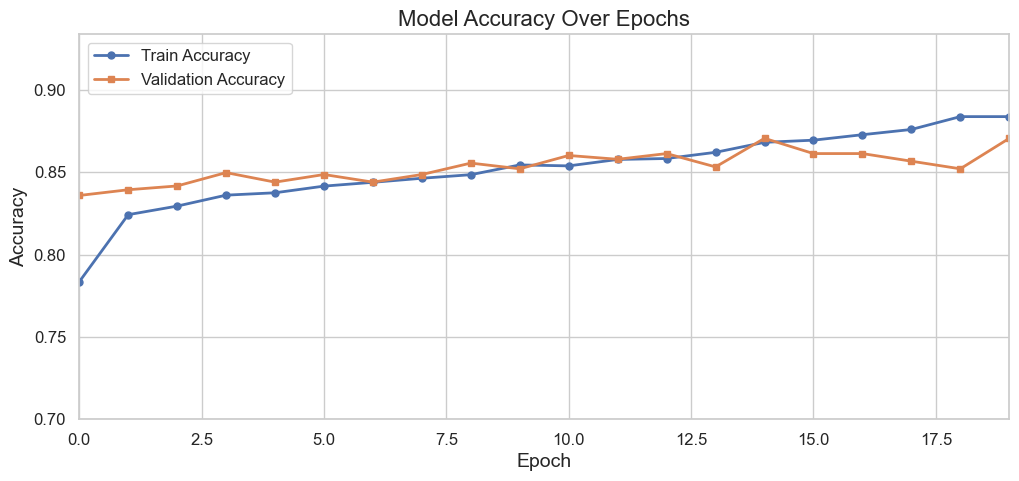

In [257]:
# Apply the seaborn style to make plots nicer
sns.set(style="whitegrid")

# Create the figure with a specific size
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 1, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2, marker='o', markersize=5)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2, marker='s', markersize=5)

# Title and labels
plt.title('Model Accuracy Over Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=14)

# Legend
plt.legend(loc='upper left', fontsize=12)

# Set limits and ticks for readability
plt.xlim(0, len(history.history['accuracy']) - 1)
plt.ylim(0.7, max(max(history.history['accuracy']), max(history.history['val_accuracy'])) + 0.05)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

Text(92.25, 0.5, 'True Label')

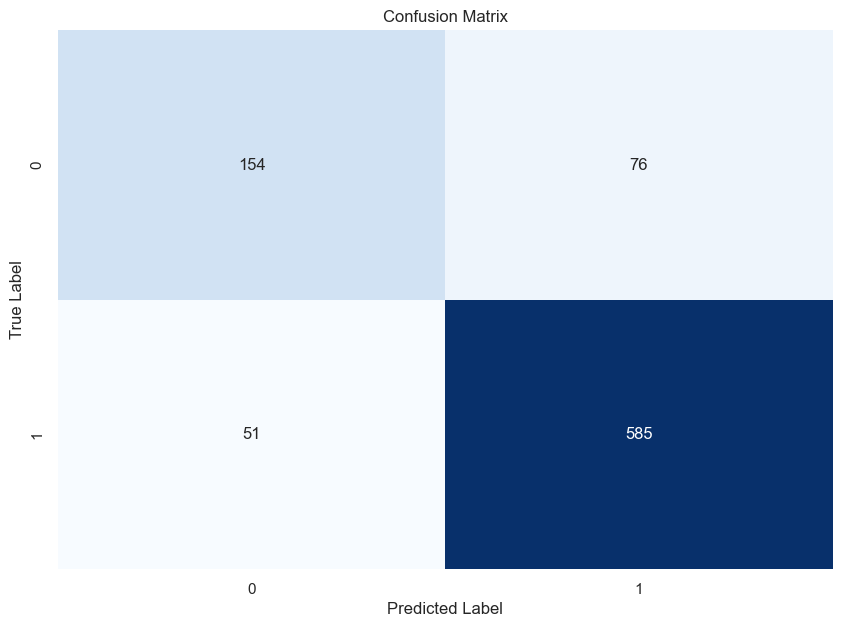

In [259]:
# Confusion matrix calculation
cm = confusion_matrix(y_test, y_pred_classes)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

In [258]:
# model.save("BiLSTM-87_val_acc-91_f_sc.h5")